In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
pkg_path = "/nfs/students/winter-term-2020/project-1/project-1/audio_classification"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

import time
import yaml
import torch
from audio_classification.tools import do_train, get_dataloader, get_model, get_transform
from audio_classification.model import lit_m11

from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, L2PGD, FGM, FGSM, L2AdditiveGaussianNoiseAttack, L2AdditiveUniformNoiseAttack, L2ClippingAwareAdditiveGaussianNoiseAttack, L2ClippingAwareAdditiveUniformNoiseAttack

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Training on device cuda.


ModuleNotFoundError: No module named 'foolbox'

In [3]:
# instantiate a model 
with open("/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/m11_bmw.yaml", "r") as config_file:
    configs = yaml.load(config_file)
path_to_checkpoint = '/nfs/homedirs/yuny/project-1/weights/' + 'sample-mnist-epoch=08-val_acc=0.79.ckpt'
model = lit_m11.load_from_checkpoint(path_to_checkpoint, cfg=configs)
fmodel = PyTorchModel(model, bounds=(-200, 200))

/nfs/homedirs/yuny/miniconda3/envs/project/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


In [4]:
# get a batch from the test data
configs['DATALOADER']['BATCH_SIZE'] = 24
_, test_loader = get_dataloader(configs, transform=get_transform(configs))
it = iter(test_loader)

In [5]:
# evaluate accuracy on clean data
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
batch = next(it)
clips = batch[0].to(device)
labels = batch[1].to(device)
out = model(clips)
preds = torch.argmax(out, dim=1)
clean_acc = accuracy(fmodel, clips, labels)
print(f"clean accuracy:  {clean_acc * 100:.1f} %")

clean accuracy:  83.3 %


In [33]:
# evaluate robustness with L-inf projected gradient descent attack
attack = LinfPGD()
epsilons = np.linspace(0.0, 0.5, num=50)

start_time = time.perf_counter()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons)
end_time = time.perf_counter()
print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

robust_accuracy = 1 - is_adv.double().mean(axis=-1)

Generated attacks in 155.42 seconds


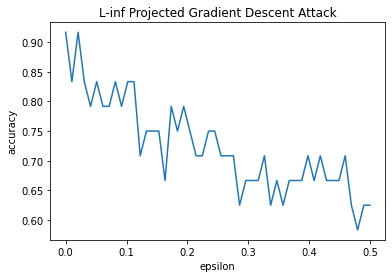

In [9]:
plt.title("L-inf Projected Gradient Descent Attack")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.plot(epsilons, robust_accuracy.to('cpu').numpy())

In [30]:
# evaluate robustness with L-2 projected gradient descent attack
attack = L2PGD()
epsilons = np.linspace(0.0, 40, num=50)

start_time = time.perf_counter()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons)
end_time = time.perf_counter()
print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

robust_accuracy = 1 - is_adv.double().mean(axis=-1)

Generated attacks in 194.45 seconds


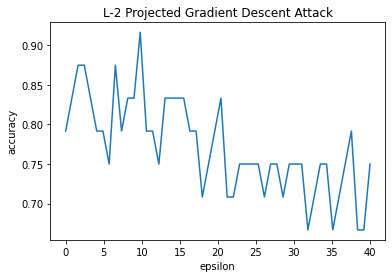

In [32]:
plt.title("L-2 Projected Gradient Descent Attack")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.plot(epsilons, robust_accuracy.to('cpu').numpy())

In [26]:
# evaluate robustness with L-2 Fast Gradient Attack
attack = FGM()
epsilons = np.linspace(0.0, 40, num=200)

start_time = time.perf_counter()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons)
end_time = time.perf_counter()
print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

robust_accuracy = 1 - is_adv.double().mean(axis=-1)

Generated attacks in 19.61 seconds


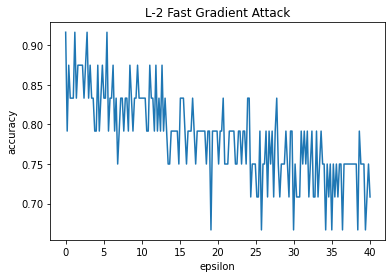

In [27]:
plt.title("L-2 Fast Gradient Attack")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.plot(epsilons, robust_accuracy.to('cpu').numpy())

In [28]:
# evaluate robustness with L-2 Fast Gradient Attack
attack = FGSM()
epsilons = np.linspace(0.0, 0.5, num=200)

start_time = time.perf_counter()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons)
end_time = time.perf_counter()
print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

robust_accuracy = 1 - is_adv.double().mean(axis=-1)

Generated attacks in 19.43 seconds


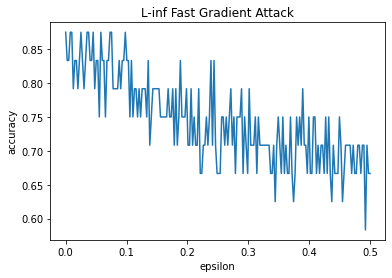

In [29]:
plt.title("L-inf Fast Gradient Attack")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.plot(epsilons, robust_accuracy.to('cpu').numpy())

In [43]:
# evaluate robustness with L-2 Additive Gaussian Noise Attack
attack = L2ClippingAwareAdditiveGaussianNoiseAttack()
epsilons = np.linspace(0.0, 40, num=200)

start_time = time.perf_counter()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons)
end_time = time.perf_counter()
print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

robust_accuracy = 1 - is_adv.double().mean(axis=-1)

Generated attacks in 6.88 seconds


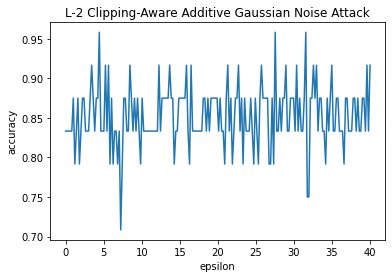

In [45]:
plt.title("L-2 Clipping-Aware Additive Gaussian Noise Attack")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.plot(epsilons, robust_accuracy.to('cpu').numpy())